In [1]:
# dependencies 
import pandas as pd 
import os
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import fatiguelife, mielke, burr, loggamma, gamma, norm, gennorm
from fitter import Fitter, get_common_distributions, get_distributions
from dython.nominal import associations

import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [2]:
dataset_colors=['pink', 'red', 'orange', 'green', 'teal','blue', 'purple', 'brown']
apex_dataset_colors = ['pink', 'red', 'orange', 'green']
emotion_color = ['green', 'red', 'orange', 'blue']
emotions = ['positive', 'negative', 'surprise', 'others']
emotions = [emotion.capitalize() for emotion in emotions]
datasets = ['CAS(ME)^2','CASME II', 'MEVIEW','MMEW','SAMM','SMIC_HS','SMIC_NIR','SMIC_VIS']
datasets_label = ['CAS$($ME$)^{2}$','CASME II', 'MEVIEW','MMEW','SAMM','SMIC_HS','SMIC_NIR','SMIC_VIS']
apex_datasets = ['CAS$($ME$)^{2}$','CASME II','MMEW','SAMM']

In [3]:
main_data = pd.read_csv('all_micro_annotations.csv')
main_data['dataset'] = main_data['dataset'].replace(['CASME_sq'], 'CAS$($ME$)^{2}$')
main_data['dataset'] = main_data['dataset'].replace(['CASME2'], 'CASME II')
datasets = main_data.dataset.unique().tolist()
datasets.sort()
datasets_apex = main_data[main_data.duration_frame_half > 0].dataset.unique().tolist() # 
emotions = ['positive', 'negative', 'surprise', 'others']

    # Clean 'emotion' column in main_data
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.lower()) # put emotion name into lower case 
main_data = main_data.replace('happy', 'happiness') # combine happiness and happy into happiness only, following terminology used in SMIC_MEAN paper
main_data = main_data.replace('other', 'others') # combine into others only, following terminology used in SMIC_MEAN paper

main_data = main_data.replace(['happiness'], 'positive')
main_data = main_data.replace(['anger', 'fear', 'contempt', 'disgust', 'sadness', 'repression'], 'negative')


# process the raw data for better graphing
emotions = [emotion.capitalize() for emotion in emotions]
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.title())
main_data = main_data.set_index('emotion').loc[emotions].reset_index()

main_data['apex_ratio'] = main_data['duration_time_half']/main_data['duration_time_full']

temp = main_data[main_data.duration_time_full <= 0.5]
temp1 = main_data[main_data.duration_time_half > 0]
temp1 = temp1[temp1.duration_time_half <= 0.25]
main_data2 = pd.concat([temp, temp1]).drop_duplicates().reset_index(drop=True)

main_data3 = main_data[(main_data.duration_time_half <= 0.25) & (main_data.duration_time_half > 0)]
main_data3 = main_data3.set_index('emotion').loc[emotions].reset_index()

In [4]:
main_data = pd.read_csv('all_micro_annotations.csv')
main_data['dataset'] = main_data['dataset'].replace(['CASME_sq'], 'CAS$($ME$)^{2}$')
main_data['dataset'] = main_data['dataset'].replace(['CASME2'], 'CASME II')
datasets = main_data.dataset.unique().tolist()
datasets.sort()
datasets_apex = main_data[main_data.duration_frame_half > 0].dataset.unique().tolist() # 
emotions = ['positive', 'negative', 'surprise', 'others']
main_data

,em,dataset,subject,video,onset,apex,offset,emotion,au,type,...,duration_time_full,duration_frame_half,duration_time_half,Inducement Code,Classes,Notes,selfReport,remarks,filename,length
0,0,CASME II,1,EP02_01f,46,59,86,happiness,12,micro-expression,...,0.205,14,0.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CASME II,1,EP03_02,131,139,161,others,18,micro-expression,...,0.155,9,0.045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,CASME II,1,EP04_02,21,54,76,others,4,micro-expression,...,0.280,34,0.170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,CASME II,1,EP04_03,31,41,56,others,4,micro-expression,...,0.130,11,0.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,CASME II,1,EP04_04,23,49,66,others,4,micro-expression,...,0.220,27,0.135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,33,MEVIEW,14,2,21,0,33,happy,L12,micro-expression,...,0.520,-20,-0.800,NaN,NaN,NaN,NaN,NaN,duel-ronaldo-miss-world.mp4,12.0
1098,34,MEVIEW,15,1,42,0,49,surprise,1.2,micro-expression,...,0.320,-41,-1.640,NaN,NaN,NaN,NaN,NaN,dvtv-ovcacek.mp4,7.0
1099,35,MEVIEW,15,2,129,0,141,surprise,1.2,micro-expression,...,0.520,-128,-5.120,NaN,NaN,NaN,NaN,NaN,dvtv-ovcacek.mp4,12.0
1100,38,MEVIEW,16,2,45,0,52,happy,12,micro-expression,...,0.320,-44,-1.760,NaN,NaN,NaN,NaN,NaN,dvtv-ovcacek.mp4,7.0


In [5]:
test = main_data3[['dataset', 'emotion','apex_ratio']].groupby(['dataset', 'emotion']).describe()
display(main_data3[['dataset', 'emotion','apex_ratio']].groupby(['dataset', 'emotion']).describe())
test.to_csv("1.csv")

apex_ratio                                          \
                              count      mean       std       min       25%   
dataset         emotion                                                       
CAS$($ME$)^{2}$ Negative       19.0  0.471578  0.105001  0.266667  0.405882   
                Others         14.0  0.423965  0.069088  0.307692  0.404167   
                Positive        7.0  0.476453  0.088510  0.357143  0.437500   
                Surprise        6.0  0.477466  0.098568  0.357143  0.389394   
CASME II        Negative       84.0  0.504187  0.163351  0.018182  0.416128   
                Others         89.0  0.500660  0.159657  0.086957  0.419753   
                Positive       23.0  0.463102  0.160924  0.146341  0.332022   
                Surprise       23.0  0.500936  0.127663  0.210000  0.466556   
MMEW            Negative       99.0  0.382576  0.118437  0.152778  0.300000   
                Others         64.0  0.368077  0.100733  0.151515  0.305254   
                Positive       32.0  0.379035  0.107874  0.187500  0.305254   
                Surprise       74.0  0.372537  0.111163  0.090909  0.289247   
SAMM            Negative       84.0  0.446441  0.146945  0.024390  0.366648   
                Others         25.0  0.414230  0.150196  0.172414  0.333333   
                Positive       19.0  0.464774  0.145654  0.150000  0.355691   
                Surprise       13.0  0.413796  0.134865  0.244444  0.307692   

                                                        
                               50%       75%       max  
dataset         emotion                                 
CAS$($ME$)^{2}$ Negative  0.461538  0.538462  0.666667  
                Others    0.433036  0.459790  0.555556  
                Positive  0.461538  0.502564  0.636364  
                Surprise  0.502564  0.551282  0.583333  
CASME II        Negative  0.503521  0.578947  1.000000  
                Others    0.508197  0.585366  1.000000  
                Positive  0.444444  0.582772  0.764706  
                Surprise  0.511628  0.561099  0.739130  
MMEW            Negative  0.384615  0.460819  0.714286  
                Others    0.370899  0.444444  0.666667  
                Positive  0.353247  0.461261  0.588235  
                Surprise  0.372283  0.446637  0.607143  
SAMM            Negative  0.419841  0.537054  0.970588  
                Others    0.380435  0.483871  0.888889  
                Positive  0.457143  0.575023  0.744681  
                Surprise  0.409091  0.506494  0.658537

In [6]:
test = main_data3[['dataset', 'emotion','apex_ratio']].groupby(['dataset']).describe()
display(main_data3[['dataset', 'emotion','apex_ratio']].groupby(['dataset']).describe())

apex_ratio                                                    \
                     count      mean       std       min       25%       50%   
dataset                                                                        
CAS$($ME$)^{2}$       46.0  0.458597  0.091948  0.266667  0.402941  0.454545   
CASME II             219.0  0.498097  0.157652  0.018182  0.413043  0.508197   
MMEW                 269.0  0.375944  0.110734  0.090909  0.300000  0.375000   
SAMM                 141.0  0.440190  0.145760  0.024390  0.343750  0.409639   

                                     
                      75%       max  
dataset                              
CAS$($ME$)^{2}$  0.528846  0.666667  
CASME II         0.581140  1.000000  
MMEW             0.450000  0.714286  
SAMM             0.538462  0.970588

In [7]:
import pandas as pd
import dython
from dython.nominal import associations
main_data3


,emotion,em,dataset,subject,video,onset,apex,offset,au,type,...,duration_frame_half,duration_time_half,Inducement Code,Classes,Notes,selfReport,remarks,filename,length,apex_ratio
0,Positive,0,CASME II,1,EP02_01f,46,59,86,12,micro-expression,...,14,0.070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341463
1,Positive,15,CASME II,2,EP09_01,26,56,125,1+12,micro-expression,...,31,0.155000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310000
2,Positive,35,CASME II,5,EP03_01,41,81,101,14,micro-expression,...,41,0.205000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.672131
3,Positive,53,CASME II,6,EP01_01,81,111,136,L14+L15,micro-expression,...,31,0.155000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553571
4,Positive,73,CASME II,9,EP05_05,46,84,96,L12,micro-expression,...,39,0.195000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.764706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,Others,292,MMEW,30,S30-04-001,1,15,33,L4,micro-expression,...,15,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454545
671,Others,293,MMEW,30,S30-04-002,1,20,45,4,micro-expression,...,20,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444444
672,Others,294,MMEW,30,S30-04-003,1,17,48,4,micro-expression,...,17,0.188889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.354167
673,Others,295,MMEW,30,S30-04-004,1,13,31,4,micro-expression,...,13,0.144444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.419355


# VERY IMPORTANT: WE WILL USE MAIN_DATA=MAIN_DATA3.COPY() FOR THE REST OF THIS CODE. 
main_data represents the micro-expressions where the apex frame is recorded. 

In [8]:
main_data=main_data3.copy()

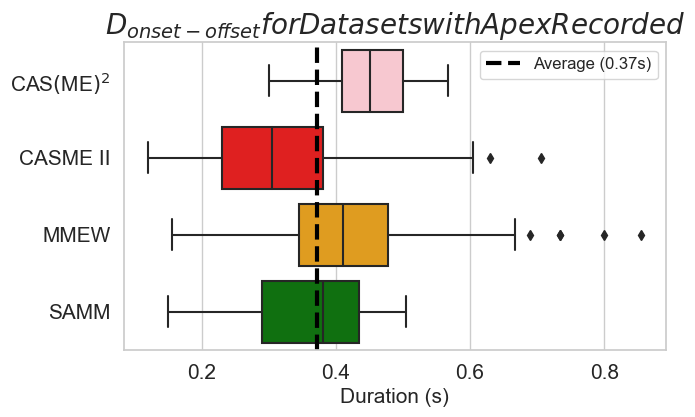

In [9]:
sns.set_theme(style="whitegrid")
fig, ax= plt.subplots(1, 1, figsize=(7, 4))
test = sns.boxplot(data=main_data, x="duration_time_full", y="dataset",  
            ax=ax, palette=apex_dataset_colors, order=apex_datasets).set_title("$D_{onset-offset} for Datasets with Apex Recorded$", fontsize=20)
ax.set_xlabel("Duration (s)", fontsize=15), ax.set_ylabel("")
ax.xaxis.set_tick_params(labelsize=15), ax.yaxis.set_tick_params(labelsize=15)
ax.axvline(x=np.mean(main_data['duration_time_full']), color='black', ls='--', label=f"Average ({np.mean(main_data3['duration_time_full']):.2f}s)", linewidth=3.0)
ax.legend(fontsize=12)


plt.savefig('1-Apex Frame - Duration_onset-offset of (Boxplot) by Dataset.png')
plt.show()

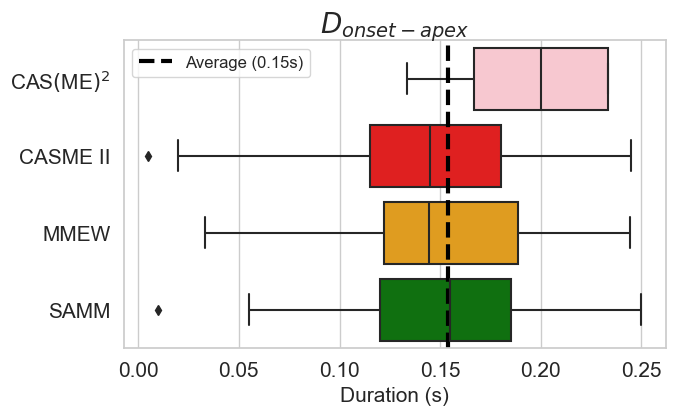

In [10]:
sns.set_theme(style="whitegrid")
fig, ax= plt.subplots(1, 1, figsize=(7, 4))
test = sns.boxplot(data=main_data, x="duration_time_half", y="dataset",  
            ax=ax, palette=apex_dataset_colors, order=apex_datasets).set_title("$D_{onset-apex}$", fontsize=20)
ax.set_xlabel("Duration (s)", fontsize=15), ax.set_ylabel("")
ax.xaxis.set_tick_params(labelsize=15), ax.yaxis.set_tick_params(labelsize=15)
ax.axvline(x=np.mean(main_data['duration_time_half']), color='black', ls='--', label=f"Average ({np.mean(main_data3['duration_time_half']):.2f}s)", linewidth=3.0)
ax.legend(fontsize=12)


plt.savefig('1-Apex Frame - Duration_onset-apex of (Boxplot) by Dataset.png', bbox_inches='tight', dpi=400)
plt.show()

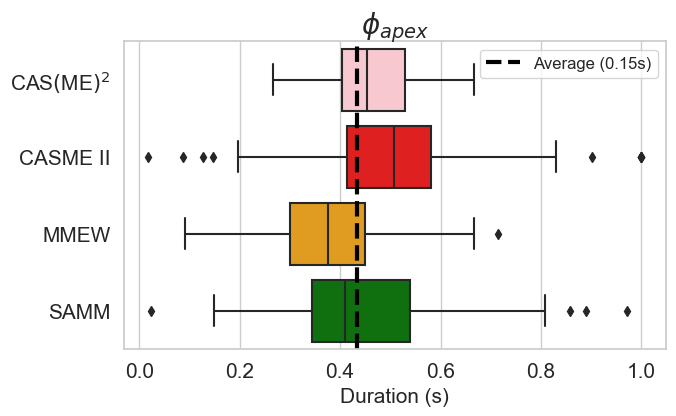

In [11]:
sns.set_theme(style="whitegrid")
fig, ax= plt.subplots(1, 1, figsize=(7, 4))
test = sns.boxplot(data=main_data, x="apex_ratio", y="dataset",  
            ax=ax, palette=apex_dataset_colors, order=apex_datasets).set_title("${\phi}_{apex}$", fontsize=20)
ax.set_xlabel("Duration (s)", fontsize=15), ax.set_ylabel("")
ax.xaxis.set_tick_params(labelsize=15), ax.yaxis.set_tick_params(labelsize=15)
ax.axvline(x=np.mean(main_data['apex_ratio']), color='black', ls='--', label=f"Average ({np.mean(main_data3['duration_time_half']):.2f}s)", linewidth=3.0)
ax.legend(fontsize=12)


plt.savefig('1-Apex Frame -phi_onset-apex of (Boxplot) by Dataset.png', bbox_inches='tight', dpi=400)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


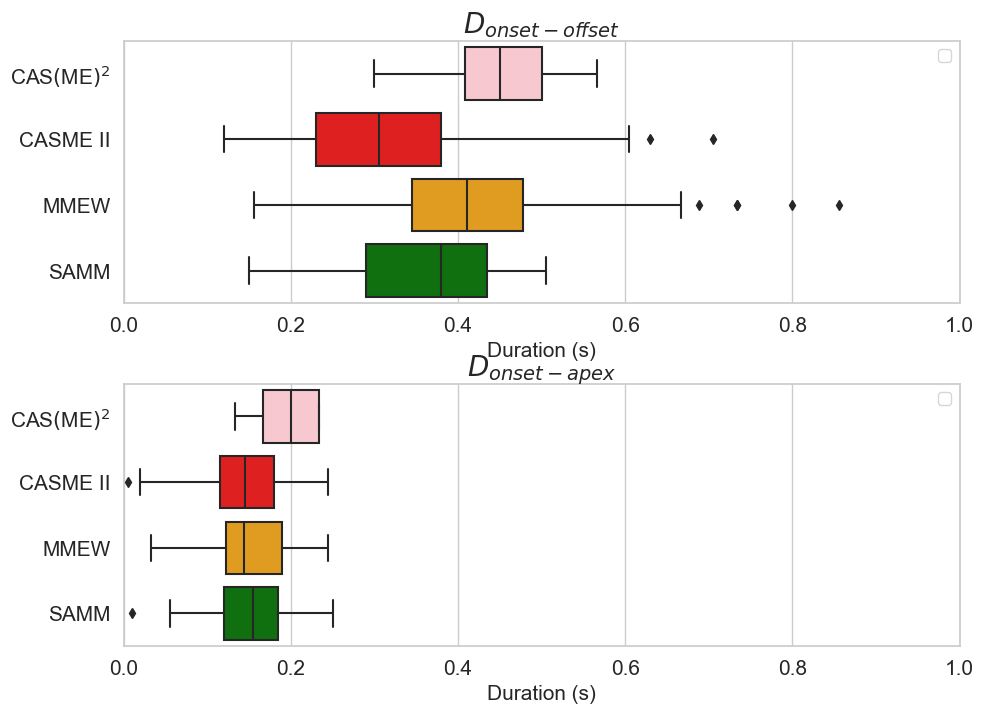

In [12]:
sns.set_theme(style="whitegrid")
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 7))
test = sns.boxplot(data=main_data, x="duration_time_full", y="dataset",  
            ax=ax, palette=apex_dataset_colors, order=apex_datasets).set_title("$D_{onset-offset}$", fontsize=20)
ax.set_xlabel("Duration (s)", fontsize=15), ax.set_ylabel(""), ax.set_xlim([0, 1])
ax.xaxis.set_tick_params(labelsize=15), ax.yaxis.set_tick_params(labelsize=15)
#ax.axvline(x=np.mean(main_data['duration_time_full']), color='black', ls='--', label=f"Average ({np.mean(main_data3['duration_time_full']):.2f}s)", linewidth=3.0)
ax.legend(fontsize=12)

fig.tight_layout() 
test = sns.boxplot(data=main_data, x="duration_time_half", y="dataset",  
            ax=ax1, palette=apex_dataset_colors, order=apex_datasets).set_title("$D_{onset-apex}$", fontsize=20)
ax1.set_xlabel("Duration (s)", fontsize=15), ax1.set_ylabel(""), ax1.set_xlim([0, 1])
ax1.xaxis.set_tick_params(labelsize=15), ax1.yaxis.set_tick_params(labelsize=15)
#ax1.axvline(x=np.mean(main_data['duration_time_full']), color='black', ls='--', label=f"Average ({np.mean(main_data3['duration_time_half']):.2f}s)", linewidth=3.0)
ax1.legend(fontsize=12)


plt.savefig('1-Apex Frame - Duration of Both (Boxplot) by Dataset.png', bbox_inches='tight', dpi=400)
plt.show()

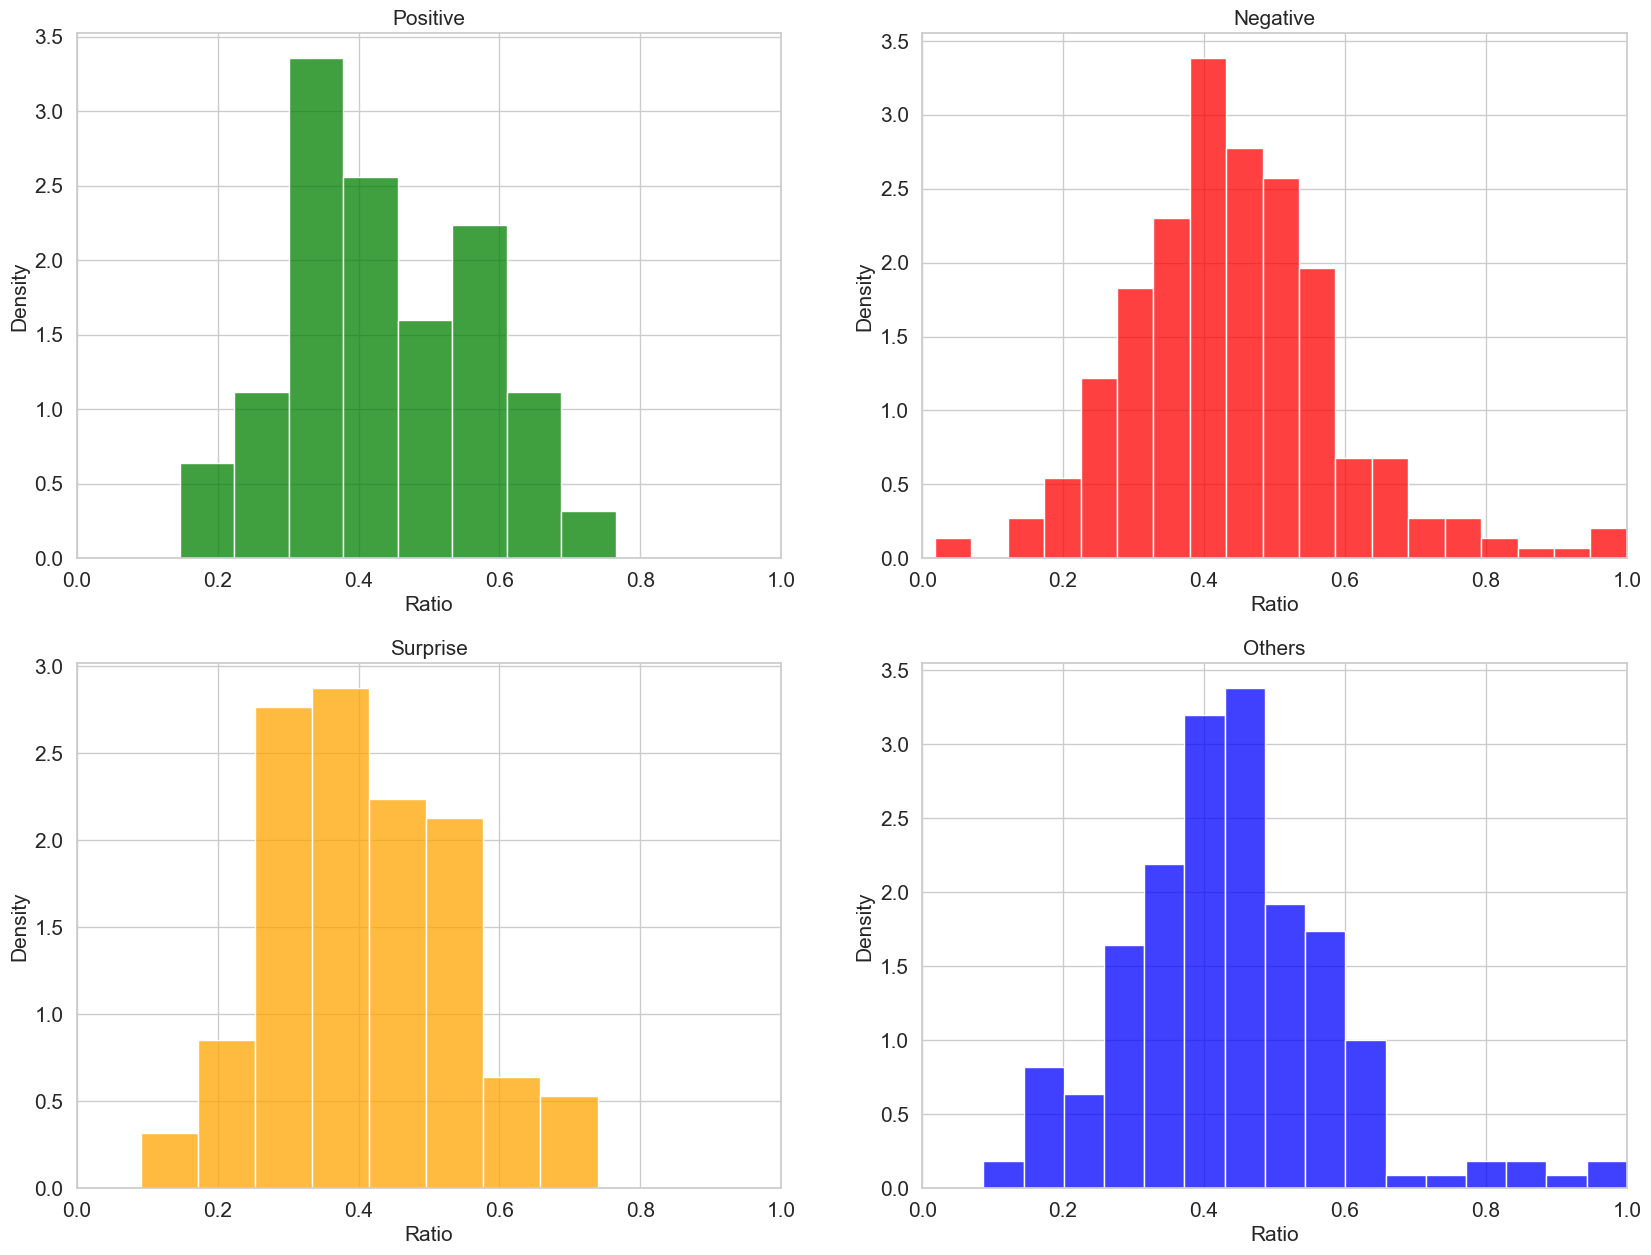

In [13]:
emotions = [emotion.capitalize() for emotion in emotions]
fig, axes = plt.subplots(2, 2, figsize=(20,15))
i = 0 
for axe in axes:
    for ax in axe:
        test = sns.histplot(data=main_data[main_data.emotion==emotions[i]], x="apex_ratio", 
                    ax=ax, color=emotion_color[i], stat="density").set_title(f"{emotions[i].title()}", fontsize=15)
        ax.set_xlabel("Ratio", fontsize=15), ax.set_ylabel("Density", fontsize=15)
        ax.set_xlim([0, 1])
        ax.xaxis.set_tick_params(labelsize=15), ax.yaxis.set_tick_params(labelsize=15)
        i = i + 1
plt.show()

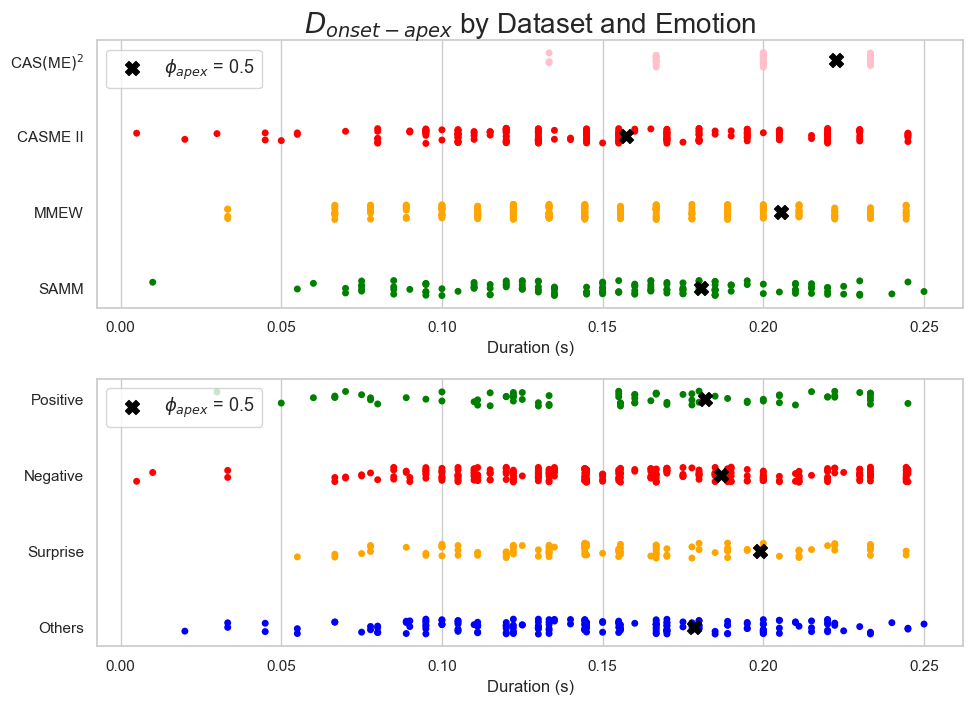

In [14]:
main_data = pd.read_csv('all_micro_annotations.csv')
main_data['dataset'] = main_data['dataset'].replace(['CASME_sq'], 'CAS$($ME$)^{2}$')
main_data['dataset'] = main_data['dataset'].replace(['CASME2'], 'CASME II')
datasets = main_data.dataset.unique().tolist()
datasets.sort()
datasets_apex = main_data[main_data.duration_frame_half > 0].dataset.unique().tolist() # 
emotions = ['positive', 'negative', 'surprise', 'others']

    # Clean 'emotion' column in main_data
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.lower()) # put emotion name into lower case 
main_data = main_data.replace('happy', 'happiness') # combine happiness and happy into happiness only, following terminology used in SMIC_MEAN paper
main_data = main_data.replace('other', 'others') # combine into others only, following terminology used in SMIC_MEAN paper

main_data = main_data.replace(['happiness'], 'positive')
main_data = main_data.replace(['anger', 'fear', 'contempt', 'disgust', 'sadness', 'repression'], 'negative')


# process the raw data for better graphing
emotions = [emotion.capitalize() for emotion in emotions]
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.title())
main_data = main_data.set_index('emotion').loc[emotions].reset_index()

main_data['apex_ratio'] = main_data['duration_time_half']/main_data['duration_time_full']

temp = main_data[main_data.duration_time_full <= 0.5]
temp1 = main_data[main_data.duration_time_half > 0]
temp1 = temp1[temp1.duration_time_half <= 0.25]
main_data2 = pd.concat([temp, temp1]).drop_duplicates().reset_index(drop=True)

main_data3 = main_data[(main_data.duration_time_half <= 0.25) & (main_data.duration_time_half > 0)]
main_data3 = main_data3.set_index('emotion').loc[emotions].reset_index()

# fig, ax1= plt.subplots(1, 1, figsize=(7, 7))
# fig.tight_layout() 
# sns.stripplot(data=main_data, x='duration_time_half', y='dataset',  ax=ax1, legend=False, zorder=1, order=apex_datasets, palette=apex_dataset_colors).set_title("Apex Location by Dataset", fontsize=15)
# ax1.scatter(x=np.mean(main_data["duration_time_full"])/2, y=0, marker='x', s=100, c='black',  zorder=2, label="Overall Midpoint")
# ax1.scatter(x=np.mean(main_data["duration_time_full"])/2, y=1, marker='x', s=100, c='black',  zorder=2)
# ax1.scatter(x=np.mean(main_data["duration_time_full"])/2, y=2, marker='x', s=100, c='black',  zorder=2)
# ax1.scatter(x=np.mean(main_data["duration_time_full"])/2, y=3, marker='x', s=100, c='black',  zorder=2)
# ax1.set_xlabel(""), ax1.set_ylabel(""), ax1.legend(loc="center left")
main_data=main_data3.copy()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
fig.tight_layout() 
sns.stripplot(data=main_data, x='duration_time_half', y='dataset',ax=ax1, legend=False, zorder=1, order=apex_datasets, palette=apex_dataset_colors).set_title("$D_{onset-apex}$ by Dataset and Emotion", fontsize=20)
ax1.scatter(x=np.mean(main_data[main_data.dataset==apex_datasets[0]]["duration_time_full"])/2, y=0, marker='X', s=100, c='black',  zorder=2, label="${\phi}_{apex}$ = 0.5")
ax1.scatter(x=np.mean(main_data[main_data.dataset==apex_datasets[1]]["duration_time_full"])/2, y=1, marker='X', s=100, c='black',  zorder=2)
ax1.scatter(x=np.mean(main_data[main_data.dataset==apex_datasets[2]]["duration_time_full"])/2, y=2, marker='X', s=100, c='black',  zorder=2)
ax1.scatter(x=np.mean(main_data[main_data.dataset==apex_datasets[3]]["duration_time_full"])/2, y=3, marker='X', s=100, c='black',  zorder=2)
ax1.set_ylabel(""), ax1.set_xlabel("Duration (s)"), ax1.legend(loc="upper left", fontsize=13)


# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
# fig.tight_layout() 
# sns.stripplot(data=main_data, x='duration_time_half', y='emotion',  ax=ax1, legend=False, zorder=1, order=emotions, palette=emotion_color).set_title("Apex Location by Emotion", fontsize=15)
# ax1.scatter(x=np.mean(main_data["duration_time_full"])/2, y=0, marker='X', s=100, c='black',  zorder=2, label="Overall Midpoint")
# ax1.scatter(x=np.mean(main_data["duration_time_full"])/2, y=1, marker='X', s=100, c='black',  zorder=2)
# ax1.scatter(x=np.mean(main_data["duration_time_full"])/2, y=2, marker='X', s=100, c='black',  zorder=2)
# ax1.scatter(x=np.mean(main_data["duration_time_full"])/2, y=3, marker='X', s=100, c='black',  zorder=2)
# ax1.set_xlabel(""), ax1.set_ylabel(""), ax1.legend(loc="center left")

fig.tight_layout() 
sns.stripplot(data=main_data, x='duration_time_half', y='emotion',ax=ax2, legend=False, zorder=1, order=emotions, palette=emotion_color)
ax2.scatter(x=np.mean(main_data[main_data.emotion==emotions[0]]["duration_time_full"])/2, y=0, marker='X', s=100, c='black',  zorder=2, label="${\phi}_{apex}$ = 0.5")
ax2.scatter(x=np.mean(main_data[main_data.emotion==emotions[1]]["duration_time_full"])/2, y=1, marker='X', s=100, c='black',  zorder=2)
ax2.scatter(x=np.mean(main_data[main_data.emotion==emotions[2]]["duration_time_full"])/2, y=2, marker='X', s=100, c='black',  zorder=2)
ax2.scatter(x=np.mean(main_data[main_data.emotion==emotions[3]]["duration_time_full"])/2, y=3, marker='X', s=100, c='black',  zorder=2)
ax2.set_ylabel(""), ax2.set_xlabel("Duration (s)"), ax2.legend(loc="upper left", fontsize=13)
plt.savefig('2-Apex Frame Location Dataset vs Emotion.png', bbox_inches='tight', dpi=400)
plt.show()

In [15]:
main_data

,emotion,em,dataset,subject,video,onset,apex,offset,au,type,...,duration_frame_half,duration_time_half,Inducement Code,Classes,Notes,selfReport,remarks,filename,length,apex_ratio
0,Positive,0,CASME II,1,EP02_01f,46,59,86,12,micro-expression,...,14,0.070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341463
1,Positive,15,CASME II,2,EP09_01,26,56,125,1+12,micro-expression,...,31,0.155000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310000
2,Positive,35,CASME II,5,EP03_01,41,81,101,14,micro-expression,...,41,0.205000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.672131
3,Positive,53,CASME II,6,EP01_01,81,111,136,L14+L15,micro-expression,...,31,0.155000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553571
4,Positive,73,CASME II,9,EP05_05,46,84,96,L12,micro-expression,...,39,0.195000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.764706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,Others,292,MMEW,30,S30-04-001,1,15,33,L4,micro-expression,...,15,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454545
671,Others,293,MMEW,30,S30-04-002,1,20,45,4,micro-expression,...,20,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444444
672,Others,294,MMEW,30,S30-04-003,1,17,48,4,micro-expression,...,17,0.188889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.354167
673,Others,295,MMEW,30,S30-04-004,1,13,31,4,micro-expression,...,13,0.144444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.419355


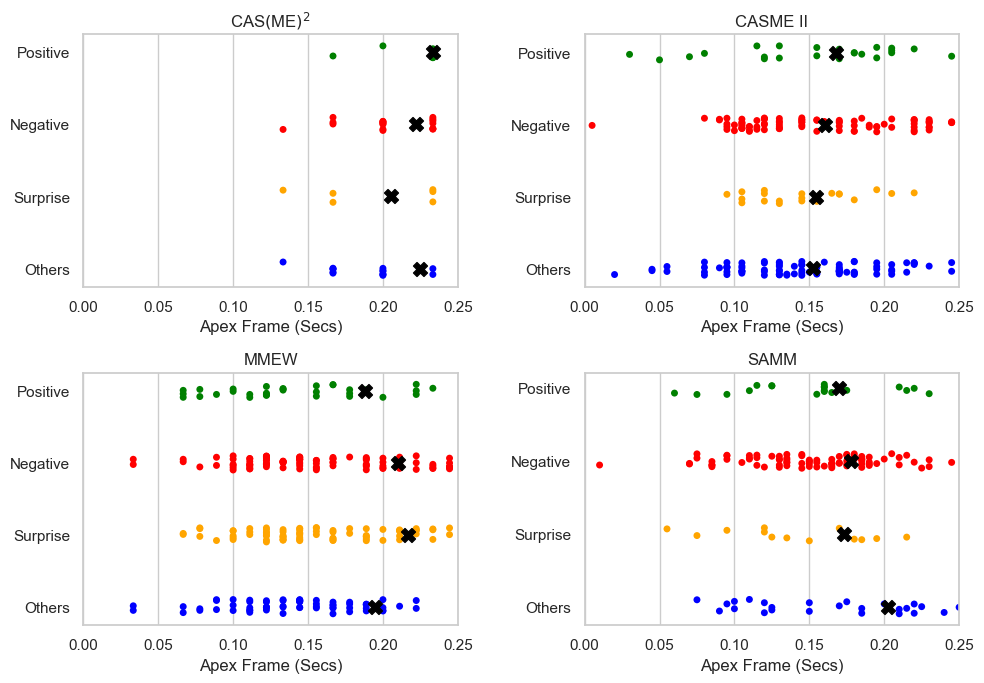

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
i = 0
for axe in axes: 
    for ax in axe: 
        sns.stripplot(data=main_data[main_data.dataset == apex_datasets[i]], x='duration_time_half', y='emotion', ax=ax, zorder=1, legend=False, palette=emotion_color).set_title(f"{apex_datasets[i]}")
        fig.tight_layout() 
        ax.set_xlim([0, 0.25])
        ax.scatter(x=np.mean(main_data[(main_data.dataset==apex_datasets[i])&(main_data.emotion==emotions[0])]["duration_time_full"])/2, y=0, marker='X', s=100, c='black',  zorder=2)
        ax.scatter(x=np.mean(main_data[(main_data.dataset==apex_datasets[i])&(main_data.emotion==emotions[1])]["duration_time_full"])/2, y=1, marker='X', s=100, c='black',  zorder=2)
        ax.scatter(x=np.mean(main_data[(main_data.dataset==apex_datasets[i])&(main_data.emotion==emotions[2])]["duration_time_full"])/2, y=2, marker='X', s=100, c='black',  zorder=2)
        ax.scatter(x=np.mean(main_data[(main_data.dataset==apex_datasets[i])&(main_data.emotion==emotions[3])]["duration_time_full"])/2, y=3, marker='X', s=100, c='black',  zorder=2)
        ax.set_xlabel('Apex Frame (Secs)'), ax.set_ylabel("")
        i = i + 1
plt.savefig('3-Apex Frame Location by Dataset and Emotion.png', bbox_inches='tight', dpi=400)
plt.show()



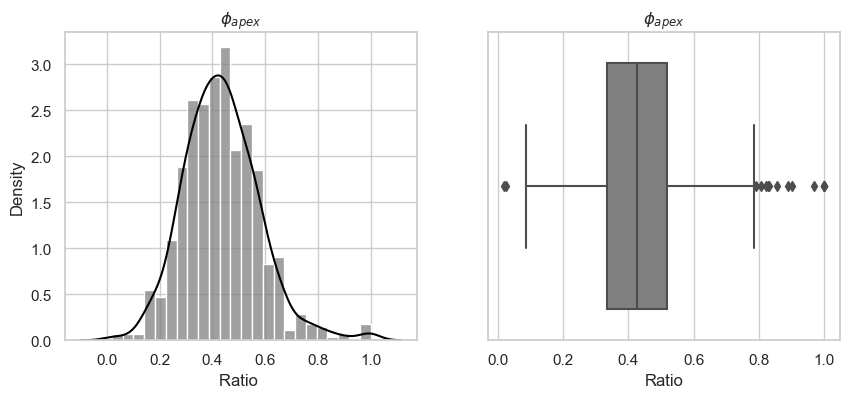

,count,mean,std,min,25%,50%,75%,max
apex_ratio,675.0,0.434629,0.143601,0.018182,0.335206,0.427083,0.517549,1.0


In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data=main_data, x='apex_ratio', color="grey", stat='density',ax=ax1).set_title("${\phi}_{apex}$")
sns.kdeplot(data=main_data, x='apex_ratio', color="black", ax=ax1)
ax1.set_xlabel("Ratio ")

sns.boxplot(main_data, x="apex_ratio", orient="v", ax=ax2, color="grey").set_title("${\phi}_{apex}$")
ax2.set_xlabel("Ratio")
plt.savefig("4- Apex frame histogram & boxplot", bbox_inches='tight', dpi=400)
plt.show()

display(main_data[['apex_ratio']].describe().T)

In [18]:
duration_dist = ['gennorm', 'fatiguelife', 'mielke', 'burr', 'loggamma', 'norm']
duration_fit = main_data['apex_ratio'].values
f = Fitter(duration_fit,  distributions=duration_dist, timeout=300)
f.fit()
f.summary(plot=False)

Fitting 6 distributions: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.13it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
mielke,34.646493,178.328145,-1978.364573,inf,0.025412,0.766004
burr,34.646494,178.327966,-1978.364548,inf,0.025412,0.766006
fatiguelife,34.761472,199.882169,-1982.642913,inf,0.027704,0.667500
gennorm,36.103645,190.094008,-1957.071087,inf,0.035761,0.345651
norm,36.252274,216.515236,-1960.812714,inf,0.044256,0.137917


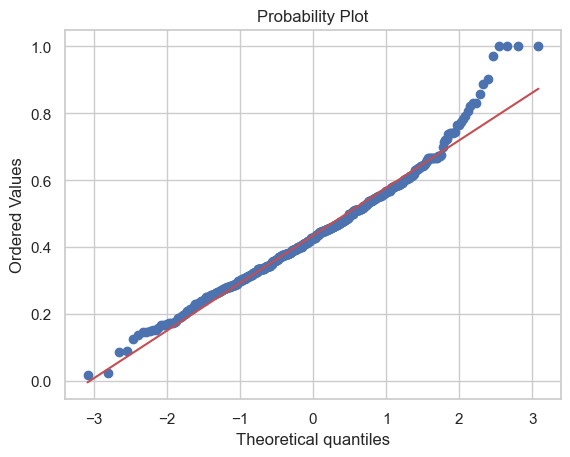

In [19]:
import pylab
test = stats.probplot(main_data['apex_ratio'], dist="norm", plot=pylab)
#plt.savefig('6-QQ Plot.png', bbox_inches='tight', dpi=400)
pylab.show()

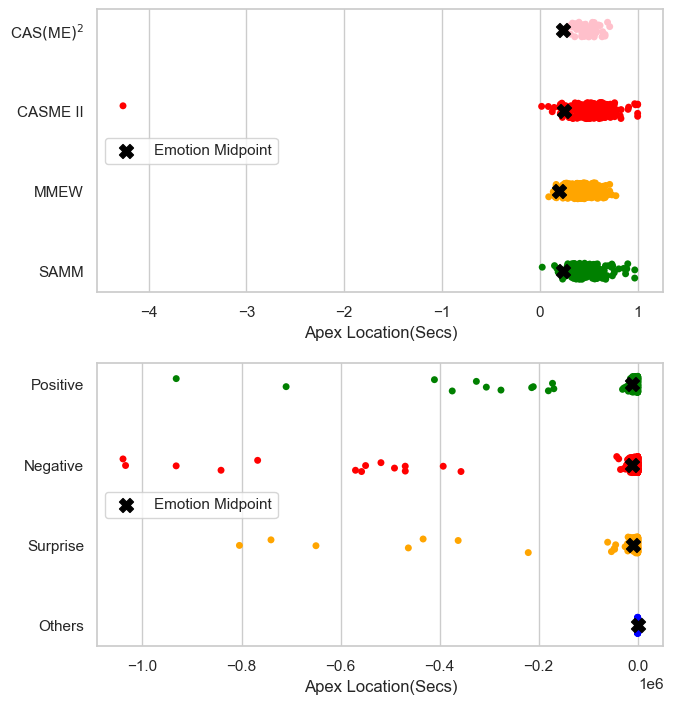

In [20]:
main_data = pd.read_csv('all_micro_annotations.csv')
main_data['dataset'] = main_data['dataset'].replace(['CASME_sq'], 'CAS$($ME$)^{2}$')
main_data['dataset'] = main_data['dataset'].replace(['CASME2'], 'CASME II')
datasets = main_data.dataset.unique().tolist()
datasets.sort()
datasets_apex = main_data[main_data.duration_frame_half > 0].dataset.unique().tolist() # 
emotions = ['positive', 'negative', 'surprise', 'others']

    # Clean 'emotion' column in main_data
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.lower()) # put emotion name into lower case 
main_data = main_data.replace('happy', 'happiness') # combine happiness and happy into happiness only, following terminology used in SMIC_MEAN paper
main_data = main_data.replace('other', 'others') # combine into others only, following terminology used in SMIC_MEAN paper

main_data = main_data.replace(['happiness'], 'positive')
main_data = main_data.replace(['anger', 'fear', 'contempt', 'disgust', 'sadness', 'repression'], 'negative')


# process the raw data for better graphing
emotions = [emotion.capitalize() for emotion in emotions]
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.title())
main_data = main_data.set_index('emotion').loc[emotions].reset_index()

main_data['apex_ratio'] = main_data['duration_time_half']/main_data['duration_time_full']

temp = main_data[main_data.duration_time_full <= 0.5]
temp1 = main_data[main_data.duration_time_half > 0]
temp1 = temp1[temp1.duration_time_half <= 0.25]
main_data2 = pd.concat([temp, temp1]).drop_duplicates().reset_index(drop=True)

main_data3 = main_data[(main_data.duration_time_half <= 0.25) & (main_data.duration_time_half > 0)]
main_data3 = main_data3.set_index('emotion').loc[emotions].reset_index()
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(7, 7))

fig.tight_layout() 
sns.stripplot(data=main_data, x='apex_ratio', y='dataset',ax=ax2, legend=False, zorder=1, order=apex_datasets, palette=apex_dataset_colors).set_title("")
ax2.scatter(x=np.mean(main_data[main_data.dataset==apex_datasets[0]]["apex_ratio"])/2, y=0, marker='X', s=100, c='black',  zorder=2, label="Emotion Midpoint")
ax2.scatter(x=np.mean(main_data[main_data.dataset==apex_datasets[1]]["apex_ratio"])/2, y=1, marker='X', s=100, c='black',  zorder=2)
ax2.scatter(x=np.mean(main_data[main_data.dataset==apex_datasets[2]]["apex_ratio"])/2, y=2, marker='X', s=100, c='black',  zorder=2)
ax2.scatter(x=np.mean(main_data[main_data.dataset==apex_datasets[3]]["apex_ratio"])/2, y=3, marker='X', s=100, c='black',  zorder=2)
ax2.set_ylabel(""), ax2.set_xlabel("Apex Location(Secs)"), ax2.legend(loc="center left")

fig.tight_layout() 
sns.stripplot(data=main_data, x='apex_ratio', y='emotion',ax=ax1, legend=False, zorder=1, order=emotions, palette=emotion_color).set_title("")
ax1.scatter(x=np.mean(main_data[main_data.emotion==emotions[0]]["apex_ratio"])/2, y=0, marker='X', s=100, c='black',  zorder=2, label="Emotion Midpoint")
ax1.scatter(x=np.mean(main_data[main_data.emotion==emotions[1]]["apex_ratio"])/2, y=1, marker='X', s=100, c='black',  zorder=2)
ax1.scatter(x=np.mean(main_data[main_data.emotion==emotions[2]]["apex_ratio"])/2, y=2, marker='X', s=100, c='black',  zorder=2)
ax1.scatter(x=np.mean(main_data[main_data.emotion==emotions[3]]["apex_ratio"])/2, y=3, marker='X', s=100, c='black',  zorder=2)
ax1.set_ylabel(""), ax1.set_xlabel("Apex Location(Secs)"), ax1.legend(loc="center left")
#plt.savefig('2-Apex Frame Location by Emotion.png')

plt.show()

In [21]:
#Code used to find best fitting distributions
duration_dist = ['gennorm', 'fatiguelife', 'mielke', 'burr', 'loggamma', 'norm']
duration_fit = main_data['apex_ratio'].values
f = Fitter(duration_fit,  distributions=duration_dist, timeout=300)
f.fit()
f.summary(plot=False)

Fitting 6 distributions: 100%|███████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.35it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
loggamma,2.616086e-09,7947.115444,-29475.633567,inf,0.992740,0.000000e+00
norm,7.126609e-09,6068.952568,-28378.262411,inf,0.449519,1.025161e-203
gennorm,7.426983e-09,4476.685304,-28325.762288,inf,0.379389,4.564222e-143
fatiguelife,7.717159e-09,inf,-28283.526417,3.154734,0.954628,0.000000e+00
burr,7.758120e-09,3298.237440,-28270.687819,inf,0.674138,0.000000e+00


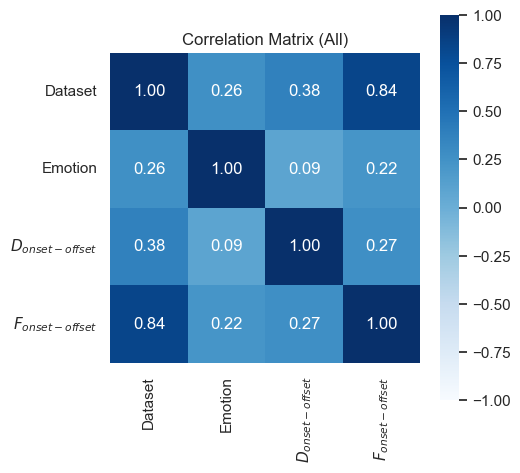

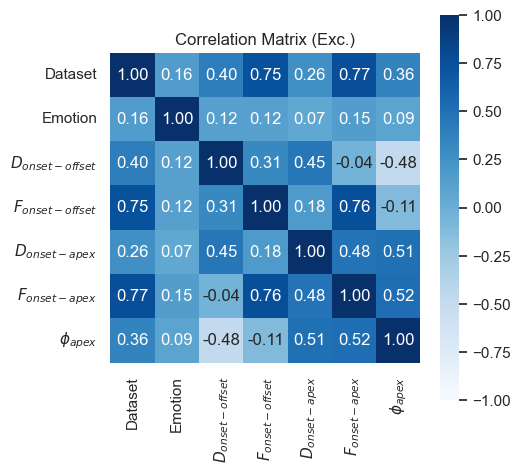

,Dataset,Emotion,$D_{onset-offset}$,$F_{onset-offset}$,$D_{onset-apex}$,$F_{onset-apex}$,${\phi}_{apex}$
Dataset,1.00,0.16,0.40,0.75,0.26,0.77,0.36
Emotion,0.16,1.00,0.12,0.12,0.07,0.15,0.09
$D_{onset-offset}$,0.40,0.12,1.00,0.31,0.45,-0.04,-0.48
$F_{onset-offset}$,0.75,0.12,0.31,1.00,0.18,0.76,-0.11
$D_{onset-apex}$,0.26,0.07,0.45,0.18,1.00,0.48,0.51
$F_{onset-apex}$,0.77,0.15,-0.04,0.76,0.48,1.00,0.52
${\phi}_{apex}$,0.36,0.09,-0.48,-0.11,0.51,0.52,1.00


In [22]:
main_data = pd.read_csv('all_micro_annotations.csv')
main_data['dataset'] = main_data['dataset'].replace(['CASME_sq'], 'CAS$($ME$)^{2}$')
main_data['dataset'] = main_data['dataset'].replace(['CASME2'], 'CASME II')
datasets = main_data.dataset.unique().tolist()
datasets.sort()
datasets_apex = main_data[main_data.duration_frame_half > 0].dataset.unique().tolist() # 
emotions = ['positive', 'negative', 'surprise', 'others']

    # Clean 'emotion' column in main_data
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.lower()) # put emotion name into lower case 
main_data = main_data.replace('happy', 'happiness') # combine happiness and happy into happiness only, following terminology used in SMIC_MEAN paper
main_data = main_data.replace('other', 'others') # combine into others only, following terminology used in SMIC_MEAN paper

main_data = main_data.replace(['happiness'], 'positive')
main_data = main_data.replace(['anger', 'fear', 'contempt', 'disgust', 'sadness', 'repression'], 'negative')


# process the raw data for better graphing
emotions = [emotion.capitalize() for emotion in emotions]
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.title())
main_data = main_data.set_index('emotion').loc[emotions].reset_index()

main_data['apex_ratio'] = main_data['duration_time_half']/main_data['duration_time_full']

temp = main_data[main_data.duration_time_full <= 0.5]
temp1 = main_data[main_data.duration_time_half > 0]
temp1 = temp1[temp1.duration_time_half <= 0.25]
main_data2 = pd.concat([temp, temp1]).drop_duplicates().reset_index(drop=True)

main_data3 = main_data[(main_data.duration_time_half <= 0.25) & (main_data.duration_time_half > 0)]
main_data3 = main_data3.set_index('emotion').loc[emotions].reset_index()


main_data=main_data.rename(columns={'dataset':'Dataset', 'emotion':"Emotion", "duration_frame_full":"$F_{onset-offset}$", 
                                   "duration_frame_half": "$F_{onset-apex}$", "duration_time_full":"$D_{onset-offset}$",
                                   "duration_time_half":"$D_{onset-apex}$"})
complete_correlation= associations(main_data[['Dataset', 'Emotion',  "$D_{onset-offset}$","$F_{onset-offset}$"
                                             ]], 
                                   figsize=(5,5), title="Correlation Matrix (All)",
                                   filename="5- Apex Frame correlation matrix (All).png", 
                                  cmap="Blues", nominal_columns=['Dataset', 'Emotion'], 
                                   numerical_columns=['$D_{onset-offset}$', "$F_{onset-offset}$"])
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='Blues', axis=None).set_precision(2)



main_data3=main_data3.rename(columns={'dataset':'Dataset', 'emotion':"Emotion", "duration_frame_full":"$F_{onset-offset}$", 
                                   "duration_frame_half": "$F_{onset-apex}$", "duration_time_full":"$D_{onset-offset}$",
                                   "duration_time_half":"$D_{onset-apex}$", "apex_ratio":"${\phi}_{apex}$"})
complete_correlation= associations(main_data3[['Dataset', 'Emotion', "$D_{onset-offset}$", "$F_{onset-offset}$",
                                              "$D_{onset-apex}$", "$F_{onset-apex}$", "${\phi}_{apex}$"]], 
                                   figsize=(5,5), title="Correlation Matrix (Exc.)",
                                   filename="5- Apex Frame correlation matrix (Exc.).png", 
                                  cmap="Blues", nominal_columns=['Dataset', 'Emotion'], 
                                   numerical_columns=['$D_{onset-offset}$',"$F_{onset-offset}$", '$D_{onset-apex}$', "$F_{onset-apex}$",'${\phi}_{apex}$'])
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='Blues', axis=None).set_precision(2)


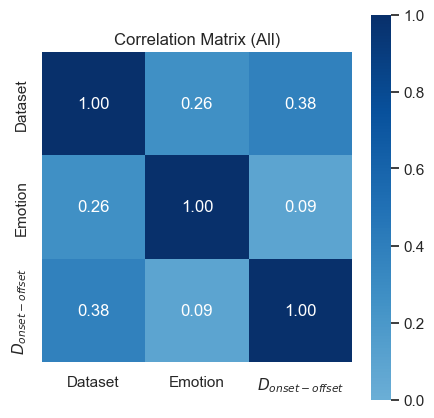

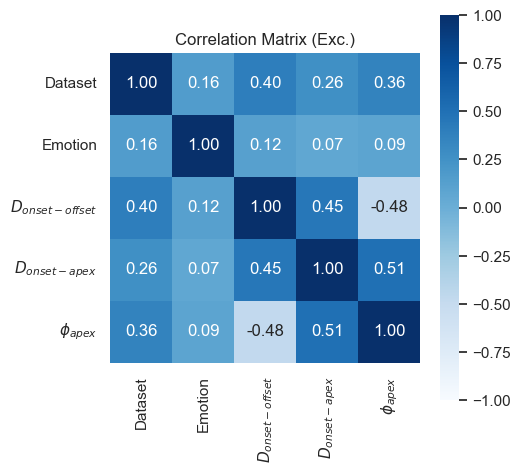

,Dataset,Emotion,$D_{onset-offset}$,$D_{onset-apex}$,${\phi}_{apex}$
Dataset,1.00,0.16,0.40,0.26,0.36
Emotion,0.16,1.00,0.12,0.07,0.09
$D_{onset-offset}$,0.40,0.12,1.00,0.45,-0.48
$D_{onset-apex}$,0.26,0.07,0.45,1.00,0.51
${\phi}_{apex}$,0.36,0.09,-0.48,0.51,1.00


In [23]:
main_data = pd.read_csv('all_micro_annotations.csv')
main_data['dataset'] = main_data['dataset'].replace(['CASME_sq'], 'CAS$($ME$)^{2}$')
main_data['dataset'] = main_data['dataset'].replace(['CASME2'], 'CASME II')
datasets = main_data.dataset.unique().tolist()
datasets.sort()
datasets_apex = main_data[main_data.duration_frame_half > 0].dataset.unique().tolist() # 
emotions = ['positive', 'negative', 'surprise', 'others']

    # Clean 'emotion' column in main_data
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.lower()) # put emotion name into lower case 
main_data = main_data.replace('happy', 'happiness') # combine happiness and happy into happiness only, following terminology used in SMIC_MEAN paper
main_data = main_data.replace('other', 'others') # combine into others only, following terminology used in SMIC_MEAN paper

main_data = main_data.replace(['happiness'], 'positive')
main_data = main_data.replace(['anger', 'fear', 'contempt', 'disgust', 'sadness', 'repression'], 'negative')


# process the raw data for better graphing
emotions = [emotion.capitalize() for emotion in emotions]
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.title())
main_data = main_data.set_index('emotion').loc[emotions].reset_index()

main_data['apex_ratio'] = main_data['duration_time_half']/main_data['duration_time_full']

temp = main_data[main_data.duration_time_full <= 0.5]
temp1 = main_data[main_data.duration_time_half > 0]
temp1 = temp1[temp1.duration_time_half <= 0.25]
main_data2 = pd.concat([temp, temp1]).drop_duplicates().reset_index(drop=True)

main_data3 = main_data[(main_data.duration_time_half <= 0.25) & (main_data.duration_time_half > 0)]
main_data3 = main_data3.set_index('emotion').loc[emotions].reset_index()


main_data=main_data.rename(columns={'dataset':'Dataset', 'emotion':"Emotion", "duration_frame_full":"$F_{onset-offset}$", 
                                   "duration_frame_half": "$F_{onset-apex}$", "duration_time_full":"$D_{onset-offset}$",
                                   "duration_time_half":"$D_{onset-apex}$"})
complete_correlation= associations(main_data[['Dataset', 'Emotion',  "$D_{onset-offset}$"
                                             ]], 
                                   figsize=(5,5), title="Correlation Matrix (All)",
                                   filename="5- Apex Frame correlation matrix (All).png", 
                                  cmap="Blues", nominal_columns=['Dataset', 'Emotion'], 
                                   numerical_columns=['$D_{onset-offset}$'])
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='Blues', axis=None).set_precision(2)



main_data3=main_data3.rename(columns={'dataset':'Dataset', 'emotion':"Emotion", "duration_frame_full":"$F_{onset-offset}$", 
                                   "duration_frame_half": "$F_{onset-apex}$", "duration_time_full":"$D_{onset-offset}$",
                                   "duration_time_half":"$D_{onset-apex}$", "apex_ratio":"${\phi}_{apex}$"})
complete_correlation= associations(main_data3[['Dataset', 'Emotion', "$D_{onset-offset}$", 
                                              "$D_{onset-apex}$", "${\phi}_{apex}$"]], 
                                   figsize=(5,5), title="Correlation Matrix (Exc.)",
                                   filename="5- Apex Frame correlation matrix (Exc.).png", 
                                  cmap="Blues", nominal_columns=['Dataset', 'Emotion'], 
                                   numerical_columns=['$D_{onset-offset}$','$D_{onset-apex}$', '${\phi}_{apex}$'])
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='Blues', axis=None).set_precision(2)
